![Stryke Force Logo](https://avatars3.githubusercontent.com/u/20849460?v=3&s=200)
# 2016 STRONGHOLD Computer Vision & Targeting
This notebook outlines the techniques used for the Stryke Force 2016 computer vision and targetting system. To facilitate understanding, we use Python and OpenCV to process step by step through the process, and show pictures with intermediate results. In the competition robot, we use C++ and OpenCV and we are only interested in the final targeting information.

First, set up this notebook.

In [17]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray'

And define a utility function for displaying an image.

In [18]:
BGR = 0
HSV = 1
BW  = 2
def displayImage(input_image, type):
    if type == BGR:
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    elif type == HSV:
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_HSV2RGB))
    elif type == BW:
        plt.imshow(input_image)
    else:
        raise("format not recognized.")
    plt.show()

### Capture a frame
Load our sample image and display it. This sample image was provided by FIRST and is similar in size, illumination, exposure and position to a frame our robot's targeting camera captures.

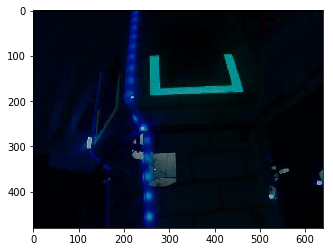

In [19]:
frame = cv2.imread("images/20.jpg")
displayImage(frame, BGR)

### The HSV Color Space
Now a short digression from our frame processing. Frames are captured by the camera in BGR format. We are going to convert our BGR frame to the [HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV) and then select just the image pixels that fall in-between two colors. Since we are looking for a specific reflected greenish color we can use a fairly narrow Hue range (first element of `hsv_lower` and `hsv_upper` below) and accomodate a large range for saturation and value/brightness (second and third elements respectively). This is usually harder to achieve with BGR images since all three channels contain color and brightness information and therefore change together with the amount of light in the image.

Blurring the image is often used to remove small features we're not interested in (noise). We'll compare our result with and without blurring the image first.
 



### Select HSV lower and upper color limits
To prepare for a competition, we use test images to select a lower and upper HSV bound color for the **inRange** operation to calibrate our camera for the particular lighting conditions on the competition field. In this exercise, we use the captured frame above as our calibration image. You can use the 'select by color' operation of an imaging program such as Photoshop to sample the target color.
![PhotoShop Screenshot](images/ps_target_color.png)

As a starting point, we use hue + 5 and hue - 5 as our upper and lower bounds. We display these colors next to part of the target image below. Note: hue is normally in the range 0-360 but OpenCV uses 0-180 so we will integer divide by 2. We'll use wide ranges for saturation and value (brightness) since these vary more with robot position and ambient lighting changes.

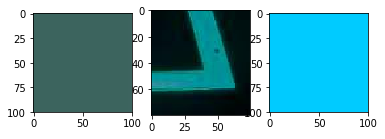

In [20]:
hue = 182 // 2
hsv_lower = (hue - 5, 100, 100)
hsv_upper = (hue + 5, 255, 255)

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(np.uint8([[hsv_lower]*100]*100), cv2.COLOR_HSV2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frame[120:200, 400:475], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(np.uint8([[hsv_upper]*100]*100), cv2.COLOR_HSV2RGB))
plt.show()

### Select pixels that fall in range of our upper and lower colors
Back to frame processing. We now want to select all pixels that fall within the HSV range of our upper and lower limits selected prior to the match. We use OpenCV's **inRange** operation to process the frame and return a new black and white image with the selected pixels in white.

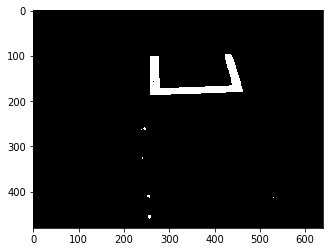

In [21]:
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
inrange_mask = cv2.inRange(hsv_frame, hsv_lower, hsv_upper)
displayImage(inrange_mask, BW)

### Removal unwanted noise in our mask image
For the 2016 robot we used a technique called [Morphological Closing](https://en.wikipedia.org/wiki/Closing_%28morphology%29) which is used for closing small holes in the mask of our target. Closing is dilation followed by erosion with a structuring element size we can tweak.

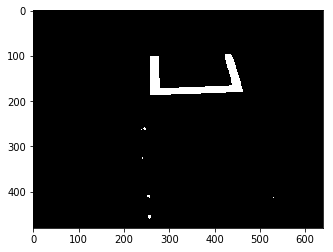

In [22]:
# a bit of trial and error finds good structuring element parameters
size = 3
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))

# dilate, then erode the mask of the target to close small holes in the target
dilated_mask = cv2.dilate(inrange_mask, structuring_element)
closed_mask  = cv2.erode(dilated_mask, structuring_element)

displayImage(closed_mask, BW)

### Find the target outline
We now use this mask of the target to accurately locate the target in the frame. We use OpenCV's **findContours** operation to find a set of points that form an outline of our target. The **findContours** operation will find an outline for each white part of the mask but we know the target will have the largest outline.  To illustrate, we will show the original frame overlaid with the target outline.

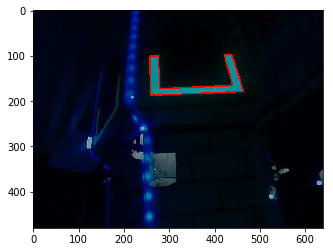

In [23]:
# contours will contain all contours
image, contours, hierarchy = cv2.findContours(closed_mask.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# find the largest contour by area
target_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]

# overlay red contour on copy of original frame and display
frame_copy = frame.copy()
cv2.drawContours(frame_copy, [target_contour], -1, (0, 0, 255), 2)
displayImage(frame_copy, BGR)
